In [40]:
%pip install transformers
%pip install tiktoken

python(6089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Note: you may need to restart the kernel to use updated packages.


python(6092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.7/906.7 kB 10.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import GPT2LMHeadModel

/Users/aj/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

torch.Size([1024, 768])


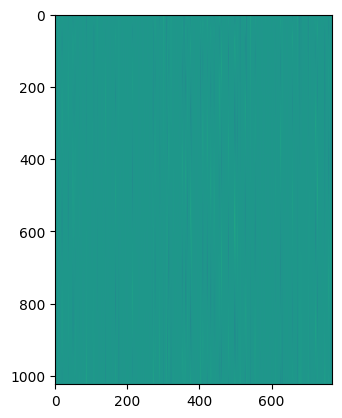

In [4]:
# Plot the position embeddings
import matplotlib.pyplot as plt
%matplotlib inline

pEmb = sd_hf['transformer.wpe.weight']
print(pEmb.shape)
plt.imshow(sd_hf['transformer.wpe.weight'])

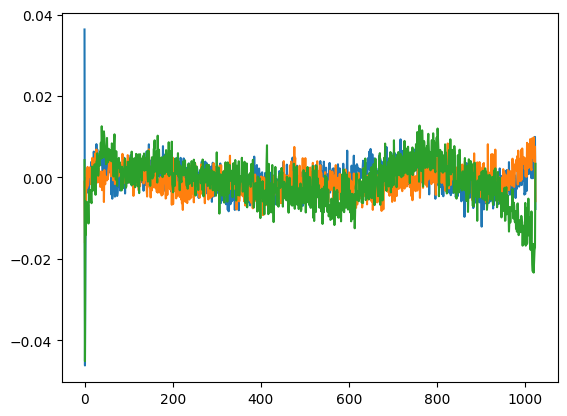

In [24]:
import numpy as np

randChannels = np.random.randint(0, pEmb.shape[1], 3)
plt.plot(pEmb[:, randChannels])

torch.Size([768, 2304])


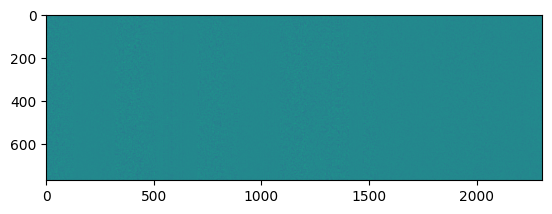

In [27]:
randAtten = sd_hf['transformer.h.1.attn.c_attn.weight']
print(randAtten.shape)
plt.imshow(randAtten)

In [49]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator('Alan Turing is ', max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Alan Turing is \xa0a great friend. He's always been a great friend. Just try to tell him your feelings on this one before you come"},
 {'generated_text': 'Alan Turing is \xa0one, and not always an American. There is no debate about his status, and his presence in the national media is of'},
 {'generated_text': 'Alan Turing is \xa0an American economist who created what is now dubbed the "Bibstone Act" with his work on how social technology could lead'},
 {'generated_text': 'Alan Turing is \xa0an accomplished computer programmer. His invention of his own computer with the goal in mind is \xa0the concept of a computer and'},
 {'generated_text': 'Alan Turing is \xa0a\xa0man.\xa0His father was\xa0John (the son of David), a\xa0father to\xa0the prophet David ('}]

In [1]:
from train_gpt2 import CausalSelfAttention, GPTConfig
import torch

config = GPTConfig()
with torch.no_grad():
    x = torch.randn((2, config.block_size, config.n_embed)) # (B, T, C)
    attn = CausalSelfAttention(GPTConfig())

    out = attn(x)
    print(out.shape)

torch.Size([2, 1024, 768])


In [24]:
from train_gpt2 import GPT
import tiktoken

computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

model = GPT.from_pretrained('gpt2')
model.eval()
model.to(computeDevice)
print(model)

Using Compute Device: mps
Loading weights from pretrained gpt: gpt2
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [29]:
# randTokens = torch.randint(0, config.vocab_size, (10, config.block_size))
# print(randTokens.shape)

# logits = model(randTokens) # takes about 10s on a CPU
# print(logits.shape)

torch.Size([10, 1024])
torch.Size([10, 1024, 50257])


In [11]:
# print(torch.mps.current_allocated_memory())
# torch.mps.empty_cache()
# print(torch.mps.current_allocated_memory())
# del randTokens
# del modelMPS

with torch.no_grad():
    randTokens = torch.randint(0, config.vocab_size, (10, config.block_size), device=computeDevice)
    logits = model(randTokens) # Takes about ~1.6s using MPS
    print(logits.shape)
print(logits[:,-1].shape)

torch.Size([10, 1024, 50257])
torch.Size([10, 50257])


In [21]:
from torch.nn import functional as F

num_return_seq = 5
max_length = 30

enc = tiktoken.get_encoding('gpt2')

tokens = enc.encode("Hello, I'm a language model,") #
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_seq, 1) # (5, 8)

x = tokens.to(computeDevice)
print(x)

tensor([[ 818, 1909,  338, 4130,  356,  561,  307, 3375,  546],
        [ 818, 1909,  338, 4130,  356,  561,  307, 3375,  546],
        [ 818, 1909,  338, 4130,  356,  561,  307, 3375,  546],
        [ 818, 1909,  338, 4130,  356,  561,  307, 3375,  546],
        [ 818, 1909,  338, 4130,  356,  561,  307, 3375,  546]],
       device='mps:0')


In [22]:
torch.manual_seed(42)
while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x) # (B, T, vocab_size)
        logits = logits[:,-1,:] # (B, vocab_size)
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1) # (5, 50)
        ix = torch.multinomial(topk_probs, 1) # (B,1)
        xcol = torch.gather(topk_indices, -1, ix)
        x = torch.cat((x, xcol), dim=1)
print(x)

tensor([[  818,  1909,   338,  4130,   356,   561,   307,  3375,   546,   281,
           772,   517,  3748,  2126,    25,   281,  2126,  1912,   319,   262,
          2126,   286,   257,  1048,   338,  1176,   286,  1842,   290,   262],
        [  818,  1909,   338,  4130,   356,   561,   307,  3375,   546,   257,
          1271,   286,  2219,  7605,   290,  8136,   326,   460,   307,   973,
           416,   597, 19599,  8517,   618,  5922,   319,   534,  2524,   357],
        [  818,  1909,   338,  4130,   356,   561,   307,  3375,   546,   703,
           284,  1064,   257,  1588,  2033,   286,  3053,  9405,   351,   262,
           976,  3053,  2209,   287,   616, 13734,    11,   422,   543,   477],
        [  818,  1909,   338,  4130,   356,   561,   307,  3375,   546,   257,
          3155,   286,  1263,   649,  3033,   326,   423,   587,  3181,   284,
           262,  4217,    13,   383,   717,   318,   257,  1080,  1444,   366],
        [  818,  1909,   338,  4130,   356,   56

In [23]:
# Decode the tokens
for i in range(num_return_seq):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(f"> {decoded}")

> In today's blog we would be talking about an even more unique idea: an idea based on the idea of a person's power of love and the
> In today's blog we would be talking about a number of common techniques and solutions that can be used by any PHP developer when developing on your site (
> In today's blog we would be talking about how to find a large amount of email addresses with the same email address in my inbox, from which all
> In today's blog we would be talking about a couple of big new features that have been brought to the PC. The first is a system called "
> In today's blog we would be talking about DICE's next product for VR headsets, and we'd like to talk about the new Rift VR headset


In [29]:
# tiny shakespeare dataset
!wget -N https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()

--2024-06-16 08:39:53--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.09s   

Last-modified header missing -- time-stamps turned off.
2024-06-16 08:39:54 (12.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [36]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

tokens = enc.encode(text[:100])
print(tokens[:15])
print(enc.decode(tokens[:15]))

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198]
First Citizen:
Before we proceed any further, hear me speak.



In [44]:
import torch

buf = torch.tensor(tokens[:24+1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])
